RQ: Is it easier to hide development of a Uranium or Plutonium weapon? 
Which can be done faster by only looking at the following: 
* number of facilites (sattelite imagery/IAEA declaration)
* amount of material entering/leaving facilities (kg? containers?)

In [1]:
import numpy as np
import random
import json

import cymetric as cym
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl

In [2]:
class Simulation: 
    
    #diversion = True if random.randint(0,1) == 1 else False
    
    def __init__(self, control, archetypes, facility, region, recipe): 
        self.control = control
        self.archetypes = {"spec": archetypes}
        self.facility = facility
        self.region = region
        self.recipe = recipe 
    
    def add_archetype(library, name):
        self.archetypes.append({"lib": library, "name": name})
        
    def add_facility(name, config):
        self.facility.append({"name": name, "config": config})
        
    def add_recipe(recipe): 
        self.recipe.append(recipe)
    
    def to_string(self):
        out = "simulation: \n"
        out += "control: " + str(self.control) + "\n"
        out += "archetypes: " + str(self.archetypes) + "\n"
        out += "facility: " + str(self.facility) + "\n"
        out += "region: " + str(self.region) + "\n"
        out += "recipe: " + str(self.recipe) + "\n"
        return out
    
    def simulation(self):
        sim = {"simulation": 
           {"control": self.control, 
            "archetypes": {"spec": self.archetypes}, 
            "facility": self.facility, 
            "region": self.region, 
            "recipe": self.recipe}}
        return sim


In [3]:
def write_input(simulation, filename):
    with open (filename, "w") as outfile:
        text = "simulation = " + str(simulation)
        outfile.write(text)
    outfile.close
    
def write_json(simulation, filename):
    with open (filename, 'w') as writeout:
        json.dump(simulation, writeout)

In [4]:
def mine(name, outcommod, outrecipe):
    return {"name": name, "config": {"Source": {"outcommod": outcommod, "outrecipe": outrecipe}}}
def enrichment(name, feedcommod, feedrecipe, productcommod, tailscommod, maxfeedinventory, maxenrich):
    return {"name": name, "config": {"Enrichment": {"feed_commod": feedcommod,"feed_recipe": feedrecipe,
                  "product_commod": productcommod,"tails_commod": tailscommod,
                  "max_feed_inventory": maxfeedinventory, "max_enrich": maxenrich}}}
def reactor(name, power_cap, ):
    pass
def sink(name, incommod):
    return {"name": name,"config": {"Sink": {"in_commods": {"val": incommod}}}}

### The simplest hider

In [5]:
simple_facilities = [
        {
            "name": "UraniumMine",
            "config": {
               "Source": {
                  "outcommod": "c_uore",
                  "outrecipe": "r_nat_u",
                   "throughput": "1e4"
               }
            }
         },
        {
            "name": "LEUenrich",
            "config": {
               "Enrichment": {
                  "feed_commod": "c_uore",
                  "feed_recipe": "r_nat_u",
                  "product_commod": "c_leu",
                  "tails_commod": "tails",
                  #"max_feed_inventory": "1e3", 
                  "max_enrich": "0.041"
               }
            }
         },
        {
            "name": "reactor",
            "config": {"Reactor": {
                  "fuel_incommods": {"val": "c_leu"},
                  "fuel_inrecipes": {"val": "r_leu"}, 
                  "fuel_outcommods": {"val": "c_spent_leu"},
                  "fuel_outrecipes": {"val": "r_leu_spent"}, 
                  "cycle_time": "9",
                  "refuel_time": "1",
                  "assem_size": "3300",
                  "n_assem_core": "3",
                  "n_assem_batch": "1",
                  "power_cap": "100" ,
               }
               }},  
        {
            "name": "SpentFuelSink",
            "config": {
               "Sink": {
                  "in_commods": {
                     "val": "c_spent_leu"
                  }
               }
            }
         }, 
#     {
#             "name": "HEUenrich",
#             "config": {
#                "Enrichment": {
#                   "feed_commod": "c_uore",
#                   "feed_recipe": "r_nat_u",
#                   "product_commod": "c_heu",
#                   "tails_commod": "c_heu_tails",
#                   'tails_assay': '0.003',
#                   "swu_capacity": '220',
#                   #"max_feed_inventory": "50",
#                   "max_enrich": "0.9"
#                }
#             }
#          },
        {
            "name": "LEUtoHEUenrich",
            "config": {
               "Enrichment": {
                  "feed_commod": "c_leu",
                  "feed_recipe": "r_leu",
                  "product_commod": "c_heu",
                  "tails_commod": "c_heu_tails",
                  "max_feed_inventory": "1e2",
                  "max_enrich": "0.9"
               }
            }
         },
        {
            "name": "HEUSink",
            "config": {
               "Sink": {
                  "in_commods": {
                     "val": "c_heu"
                  },
                   "capacity": "10",
                   "recipe_name": "r_heu"
               }
            }
         }
            ]


def set_institution(facilities):
    institution = {"name": "inst", "initialfacilitylist": {"entry": []},
                   "config": {"NullInst": None}}
    for facility in facilities:
        institution["initialfacilitylist"]["entry"].append(
            {"number": 1, "prototype": facility["name"]}
        )    
    return institution

simple_region = {"name": "SimpleHiderRegion", "config": {"NullRegion": None},
                 "institution": set_institution(simple_facilities)}

simple_archetypes = [{"lib": "cycamore","name": "Enrichment"},
                      {"lib": "cycamore","name": "Reactor"}, 
                           {"lib": "cycamore","name": "Source"},
                           {"lib": "cycamore","name": "Sink"},
                           {"lib": "agents","name": "NullRegion"},
                           {"lib": "agents", "name": "NullInst"}]

u_recipies = [{"name": "r_nat_u", "basis": "mass",
                         "nuclide": [{"id": "92235", "comp": "0.00711"},
                                     {"id": "92238", "comp": "0.99289"}]},
                        {"name": "r_heu", "basis": "mass",
                         "nuclide": [{"id": "92235", "comp": "0.9"},
                                     {"id": "92238", "comp": "0.1"}]},
                        {"name": "r_leu", "basis": "mass",
                         "nuclide": [{"id": "92235","comp": "0.04"},
                                     {"id": "92238", "comp": "0.96"}]},
                    {"name": "r_leu_spent", "basis": "mass", 
                    "nuclide": [{"id": "92235", "comp": "0.01"},
                                {"id": "92238", "comp": "0.94"},
                                {"id": "94239", "comp": "0.01"},
                                {"id": "55135", "comp": "0.3"}]}]

default_control = {"duration": "144", "startmonth": "1", "startyear": "2019",
                   "decay": "never", "explicit_inventory": "true"}

In [6]:
simple_hider = Simulation(default_control, simple_archetypes, simple_facilities, simple_region, u_recipies)
write_input({"simulation": vars(simple_hider)}, "0309base.py")

In [7]:
hider_file = "0309base.sqlite" #u_model.sqlite
db = cym.dbopen(hider_file)
ev = cym.Evaluator(db=db, write=True)

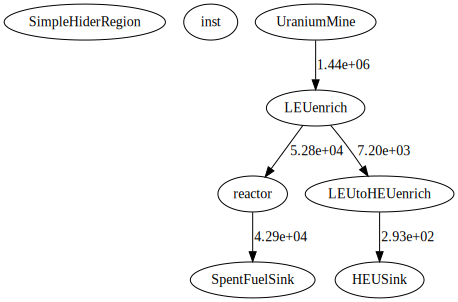

In [8]:
cym.graphs.flow_graph(ev, label = "mass")

set limits for material high for suppliers 
decrease by order of magnitude for each facility 
isolate each facility 
